In [1]:
# import

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import torchvision

from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from path import Path
import os
import json

import altair as alt
import pandas as pd

import random
#os.environ["CUDA_VISIBLE_DEVICES"] ="2, 3"

In [2]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda:2'

### MODEL (AE)

In [4]:
class Encoder (nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, latent_dims)
        self.relu = nn.ReLU()
        
        
    def forward(self, x): #x : torch.Size([64, 2, 400])
        x = torch.flatten(x, start_dim=1) # x.shape : torch.Size([64, 800])
        x = self.relu(self.fc1(x)) # x.shape : torch.Size([64, 512]) 
        x = self.fc2(x)
        return x #shape = torch.Size([64, 5])

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dims, 512)
        self.fc2 = nn.Linear(512, 800)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.sigmoid(self.fc2(z)) #z.shape : torch.Size([64, 800])
        z = torch.reshape(z, (-1, 400, 2)) #뒤에서도 사용할려면 64대신 일반화 해야함.
        return z

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## DATA

In [7]:
class DRPointData(Dataset):
    def __init__(self, root_dir, valid=False):
        self.root_dir = root_dir
        self.valid = valid
        self.files = [_ for _ in os.listdir(root_dir) if _.endswith('.json')]
        self.files = self.files[:4000]
        
    def __len__(self):
        return len(self.files)
    
    def __preproc__(self, file):
        with open(file, encoding="UTF-8") as f:
            
            np_points = np.array(json.load(f, strict=False))
            nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto').fit(np_points)
            matrix = torch.from_numpy(nbrs.kneighbors_graph(np_points).toarray())
            points = torch.from_numpy(np_points)
            max_val = torch.max(points, -2).values.view(1, -1)
            min_val = torch.min(points, -2).values.view(1, -1)
            diff = max_val - min_val 
            points = (points - min_val) / diff
        return {'points': points, #[400, 2]
               'KNN':matrix}
        
    def __getitem__(self, idx):
        json_file = os.path.join(self.root_dir, self.files[idx])
        item = self.__preproc__(json_file)
        return item
    
    def __filename__(self, idx):
        return self.files[idx]
        

In [8]:
path = Path("data_0610")
train_dr = DRPointData(path)
len(train_dr)

4000

In [9]:
dataloader = DataLoader(dataset=train_dr, batch_size=32, drop_last=True)

In [33]:
with open('label.json') as f:
    labels = np.array(json.load(f))

In [ ]:
labels

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,   gridspec_kw={'hspace': 0.1, 'wspace': 0.1})


idx = []
for i in range(4):
    idx.append(random.randint(0, len(train_dr)))

df0 = pd.DataFrame(points_data[idx[0]].numpy(), columns=['X', 'Y'])
df1 = pd.DataFrame(points_data[idx[1]].numpy(), columns=['X', 'Y'])
df2 = pd.DataFrame(points_data[idx[2]].numpy(), columns=['X', 'Y'])
df3 = pd.DataFrame(points_data[idx[3]].numpy(), columns=['X', 'Y'])

print(points_data[idx[0]].shape) #torch.Size([400, 2])

df0.plot.scatter(x='X', y='Y', ax=axes[0,0], s=1, c=labels, cmap='tab10')
df1.plot.scatter(x='X', y='Y', ax=axes[0,1], s=1, c=labels, cmap='tab10')
df2.plot.scatter(x='X', y='Y', ax=axes[1,0], s=1, c=labels, cmap='tab10')
df3.plot.scatter(x='X', y='Y', ax=axes[1,1], s=1, c=labels, cmap='tab10')

idx


## AutoEncoder (train)

In [67]:
def train(model, dataloader, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        print(epoch)
        for i, data in enumerate(dataloader, 0):
            #inputs, kNN = data['points'].to(device).float(), data['KNN'].to(device).int()

            inputs = data['points'].to(device).float()
            optimizer.zero_grad()
            x_hat = autoencoder(inputs.transpose(1, 2))
            loss = ((inputs - x_hat)**2).sum()
            loss.backward()
            optimizer.step()
    return model

In [68]:
latent_dims = 5
autoencoder = Autoencoder(latent_dims).to(device)

In [69]:
autoencoder = train(autoencoder, dataloader) #TODO AGAIN

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Variational Autoencoder (VAE)

In [20]:
class VariationalEncoder (nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, latent_dims)
        self.fc3 = nn.Linear(512, latent_dims)
        
        self.relu = nn.ReLU()
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        
        
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        mu =  self.fc2(x)
        sigma = torch.exp(self.fc3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [21]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

to train the vae, only need to add the auxillary loss in training algorithm

In [22]:
def train_vae(model, dataloader, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        print(epoch)
        for i, data in enumerate(dataloader, 0):
            inputs, kNN = data['points'].to(device).float(), data['KNN'].to(device).int()
            optimizer.zero_grad()
            x_hat = vae(inputs.transpose(1, 2))
            loss = ((inputs - x_hat)**2).sum() + vae.encoder.kl
            loss.backward()
            optimizer.step()

    return model


In [23]:
latent_dims = 5
vae = VAE(latent_dims).to(device)

In [24]:
vae = train_vae(vae, dataloader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Latent Space Exploration

In [28]:
def plot_latent(model, dataloader, latent_dims, num_batches=100):
    latent_values = []
    latent_numbers = []
    for i in range(latent_dims):
        latent_values.append(np.array([]))

    for i, x in enumerate(dataloader):
        x = x['points']
        z = model.encoder(x.to(device).float())
        z = z.to('cpu').detach().numpy()
        # 32 (batch_size)개씩 끊어서
        for j in range(latent_dims):
            latent_values[j] = np.concatenate((latent_values[j], np.array(z[:, j])))
            
#        plt.scatter(z[:, 0], z[:, 1], cmap='tab10')
        if (i > num_batches):
            fig, axes = plt.subplots(nrows=latent_dims, ncols=1, sharex=True, gridspec_kw={'hspace': 0})
            for j in range(latent_dims):
                print(f'mean: {round(np.mean(latent_values[j]), 4)}, var: {round(np.var(latent_values[j]), 4)}, std :{round(np.std(latent_values[j]), 4)} ')
                axes[j].plot(latent_values[j], np.zeros_like(latent_values[j]), 'x')
                axes[j].set_ylabel(f'{j}')
                #mean, std, 5, 95
                latent_numbers.append([np.mean(latent_values[j]), np.std(latent_values[j]), np.percentile(latent_values[j], 5), np.percentile(latent_values[j], 95)])
            break
            
    return latent_numbers

mean: 0.0974, var: 0.0511, std :0.2261 
mean: 0.8144, var: 0.0522, std :0.2284 
mean: 0.3163, var: 0.0634, std :0.2518 
mean: 0.9597, var: 0.0548, std :0.234 
mean: -2.3678, var: 0.2722, std :0.5217 


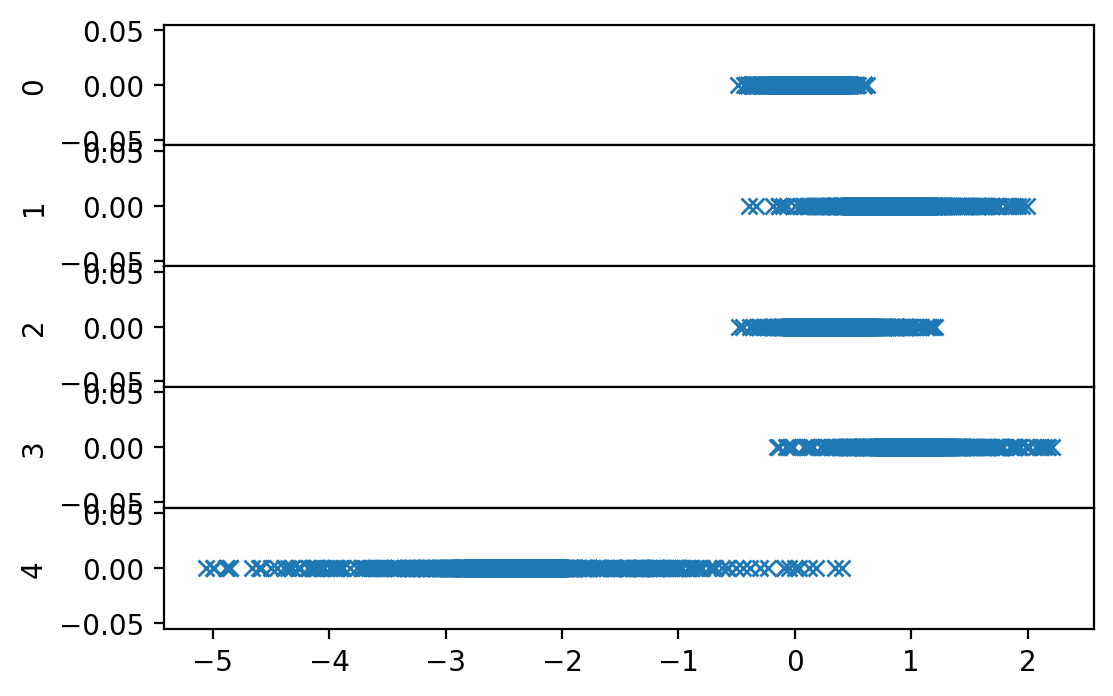

In [70]:
ae_latent_numbers = plot_latent(autoencoder, dataloader, latent_dims)

mean: -0.2857, var: 0.0437, std :0.209 
mean: -0.2468, var: 0.0433, std :0.208 
mean: -0.1105, var: 0.0799, std :0.2827 
mean: -0.2641, var: 0.1226, std :0.3501 
mean: -0.3881, var: 0.107, std :0.3272 


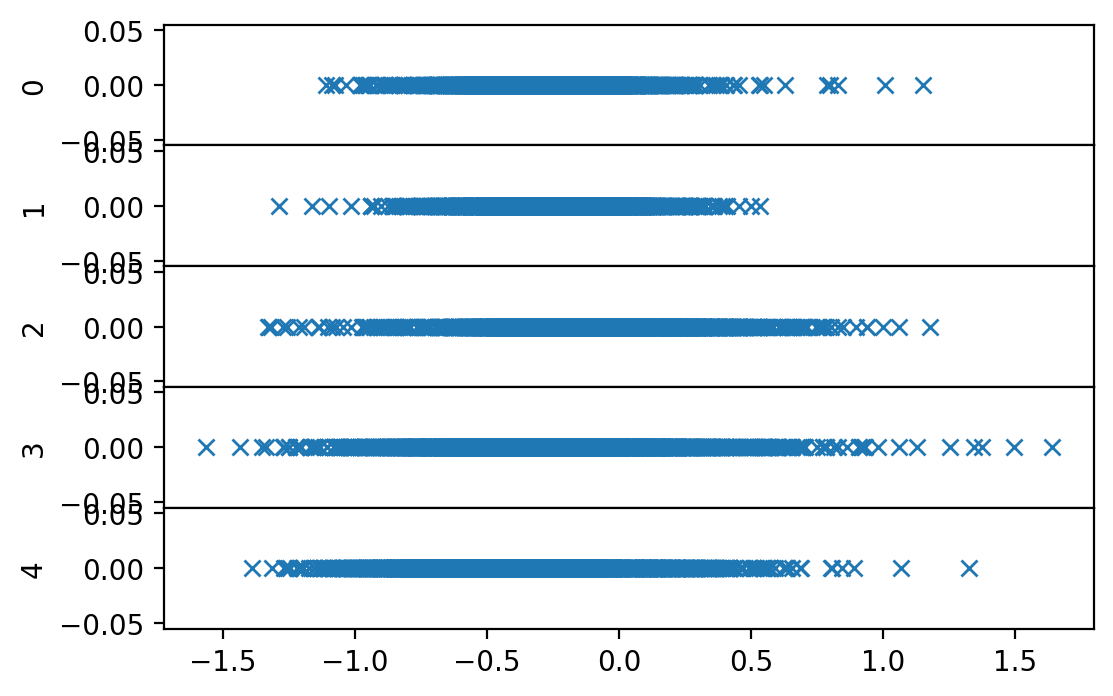

In [29]:
vae_latent_numbers = plot_latent(vae, dataloader, latent_dims)

In [64]:
def plot_reconstructed(autoencoder, dims, model, w=24, h=24, n=10, size=50):
    fig, axes = plt.subplots(nrows=dims, ncols=n, sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    #fig, axes = plt.subplots(nrows=dims, ncols=n, sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    latent_means = []
    fig.set_figheight(h)
    fig.set_figwidth(w)
#    plt.rcParams["figure.figsize"] = (8,24)
#    print(plt.rcParams["figure.figsize"])
    if (model == "ae"):
        latent_numbers = ae_latent_numbers
    elif (model == "vae"):
        latent_numbers = vae_latent_numbers
        
        
    for i in range(dims):
        latent_means.append(latent_numbers[i][0])

    latent_means = np.array(latent_means)
    for i in range(dims):
        #latent_mean, latent_std
        r0 = (latent_numbers[i][2], latent_numbers[i][3])
        for j, x in enumerate(np.linspace(*r0, n)):
            val = latent_means.copy()
            val[i] = x
            z = torch.Tensor([val]).to(device)
            x_hat = autoencoder.decoder(z)
            df = pd.DataFrame(x_hat[0].to('cpu').detach().numpy(), columns=['X', 'Y'])
            df.plot.scatter(x='X', y='Y', ax=axes[i,j], s=size, c=labels, cmap='tab10')

                        
    plt.show()

            


In [ ]:
plot_reconstructed(autoencoder, latent_dims, "ae")

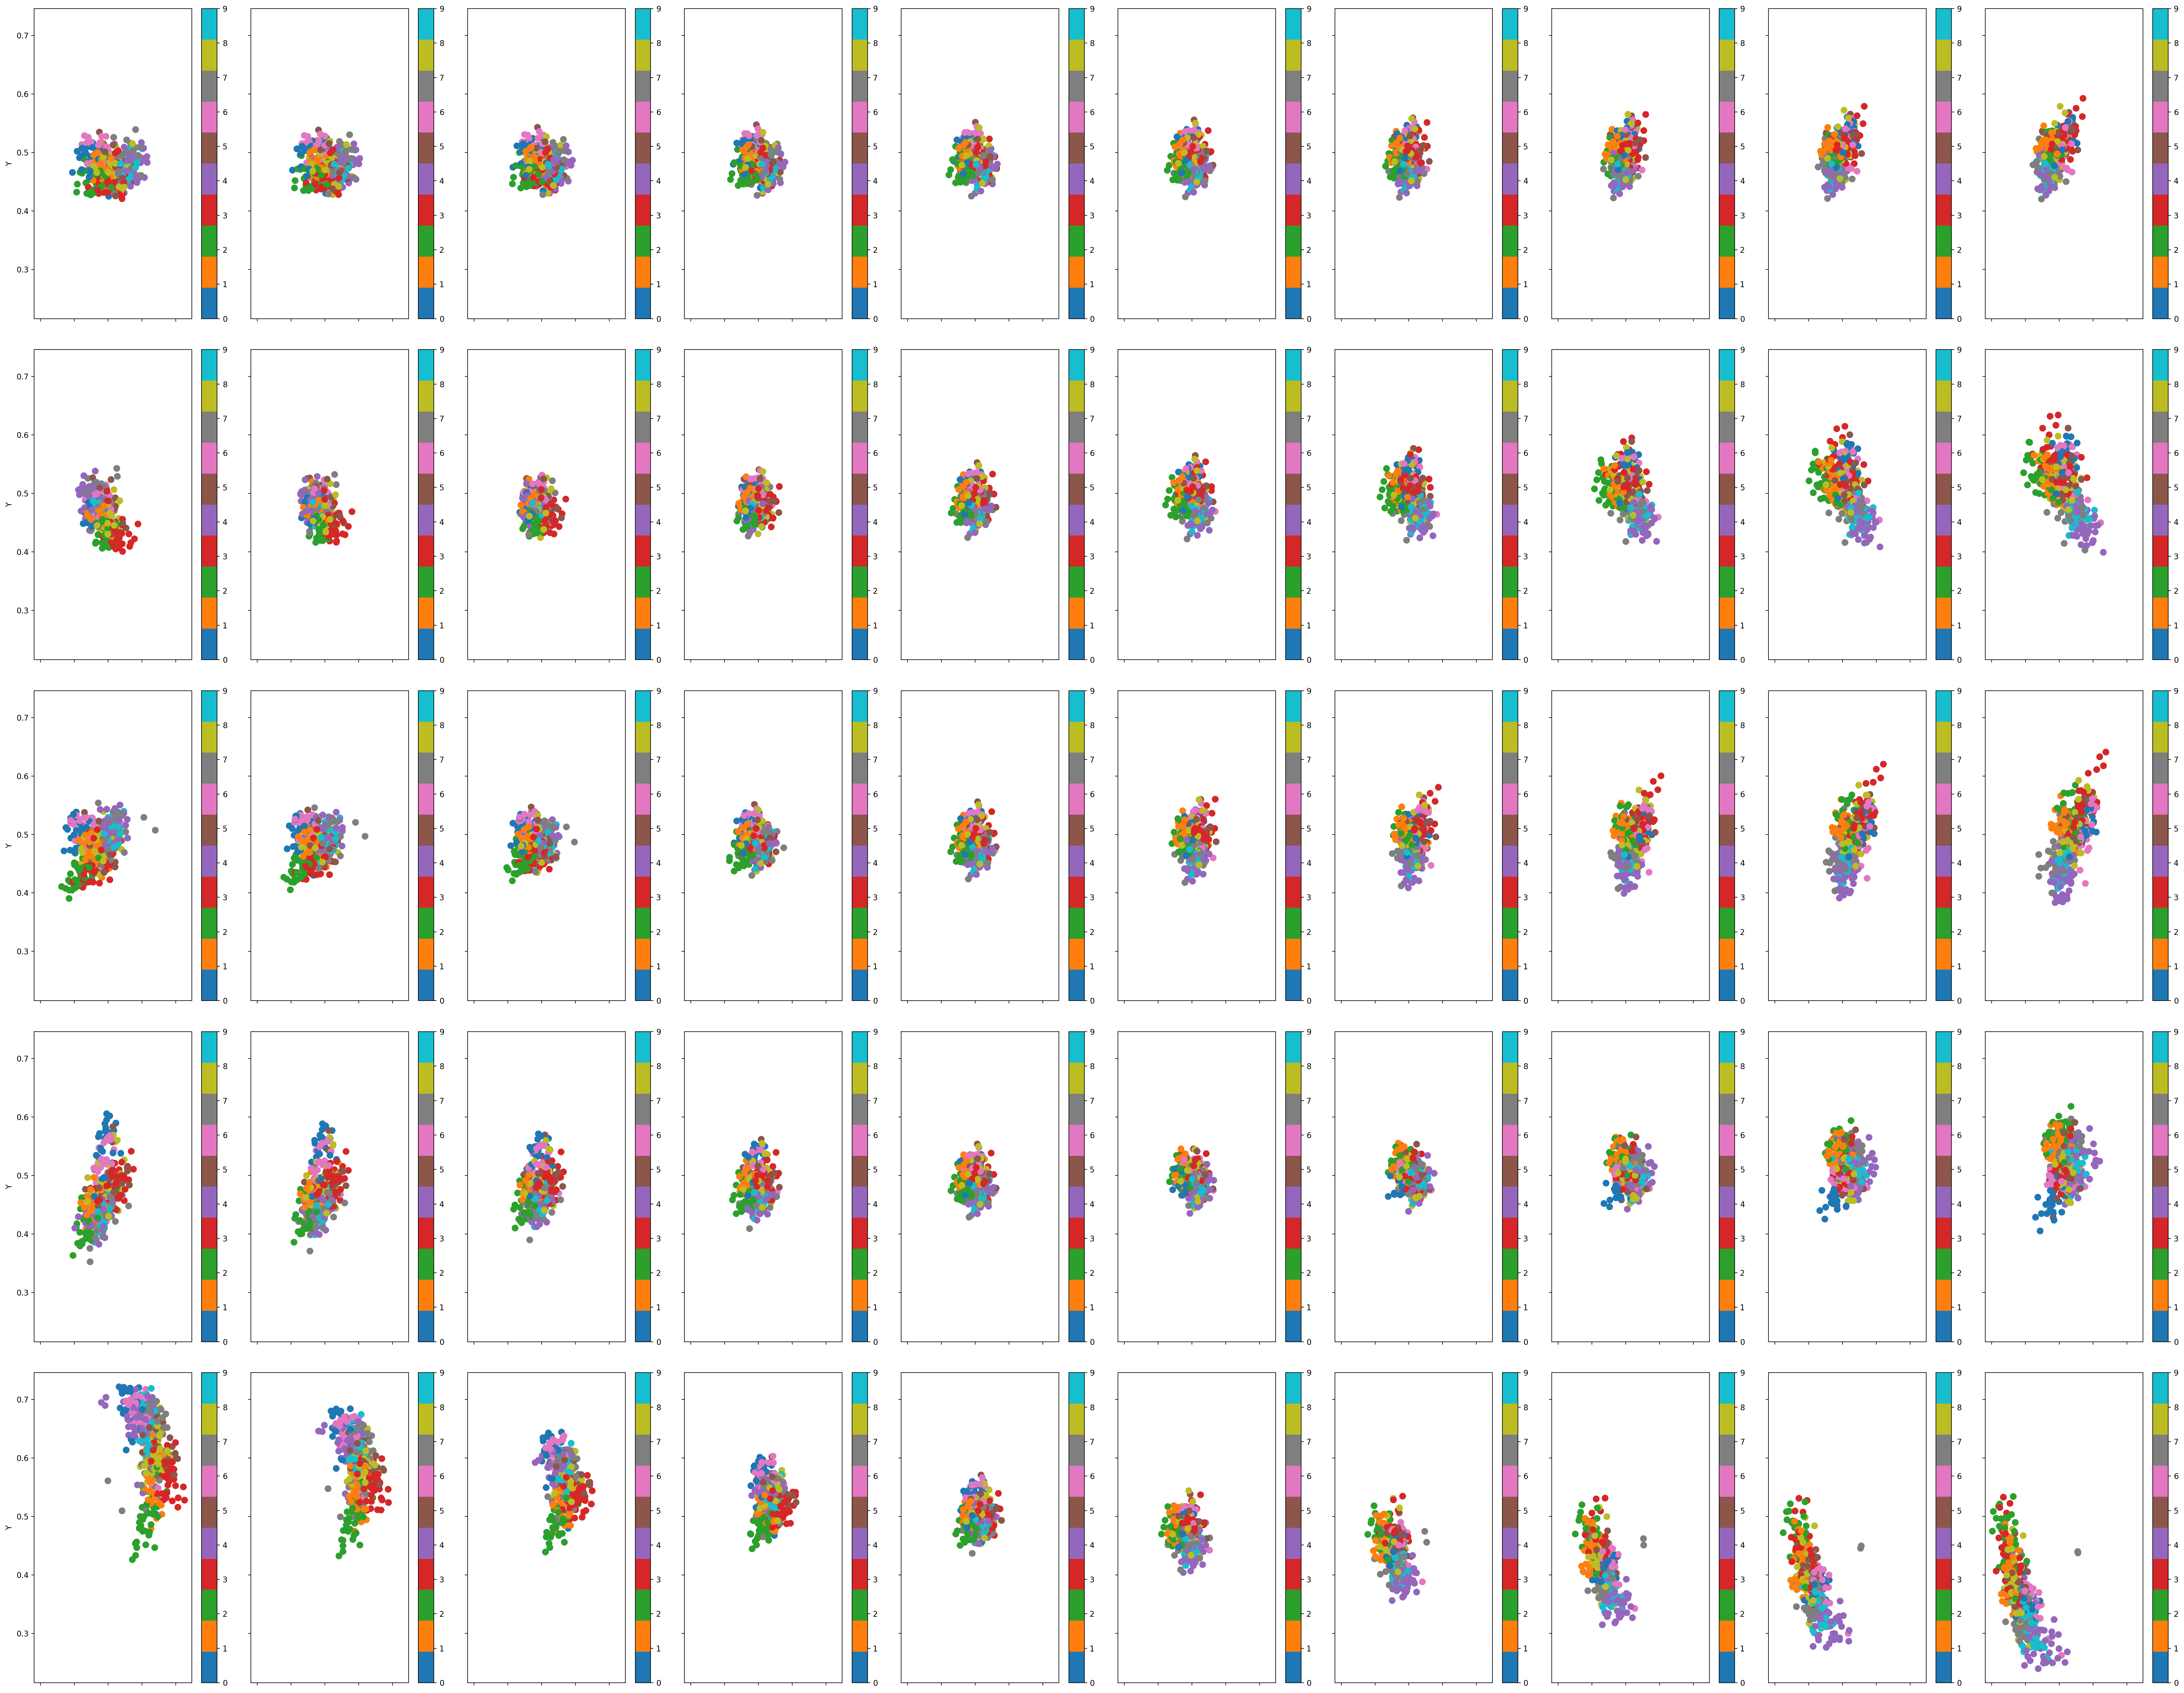

In [71]:
plot_reconstructed(autoencoder, latent_dims, "ae", n=10, h=40, w=50, size=60)

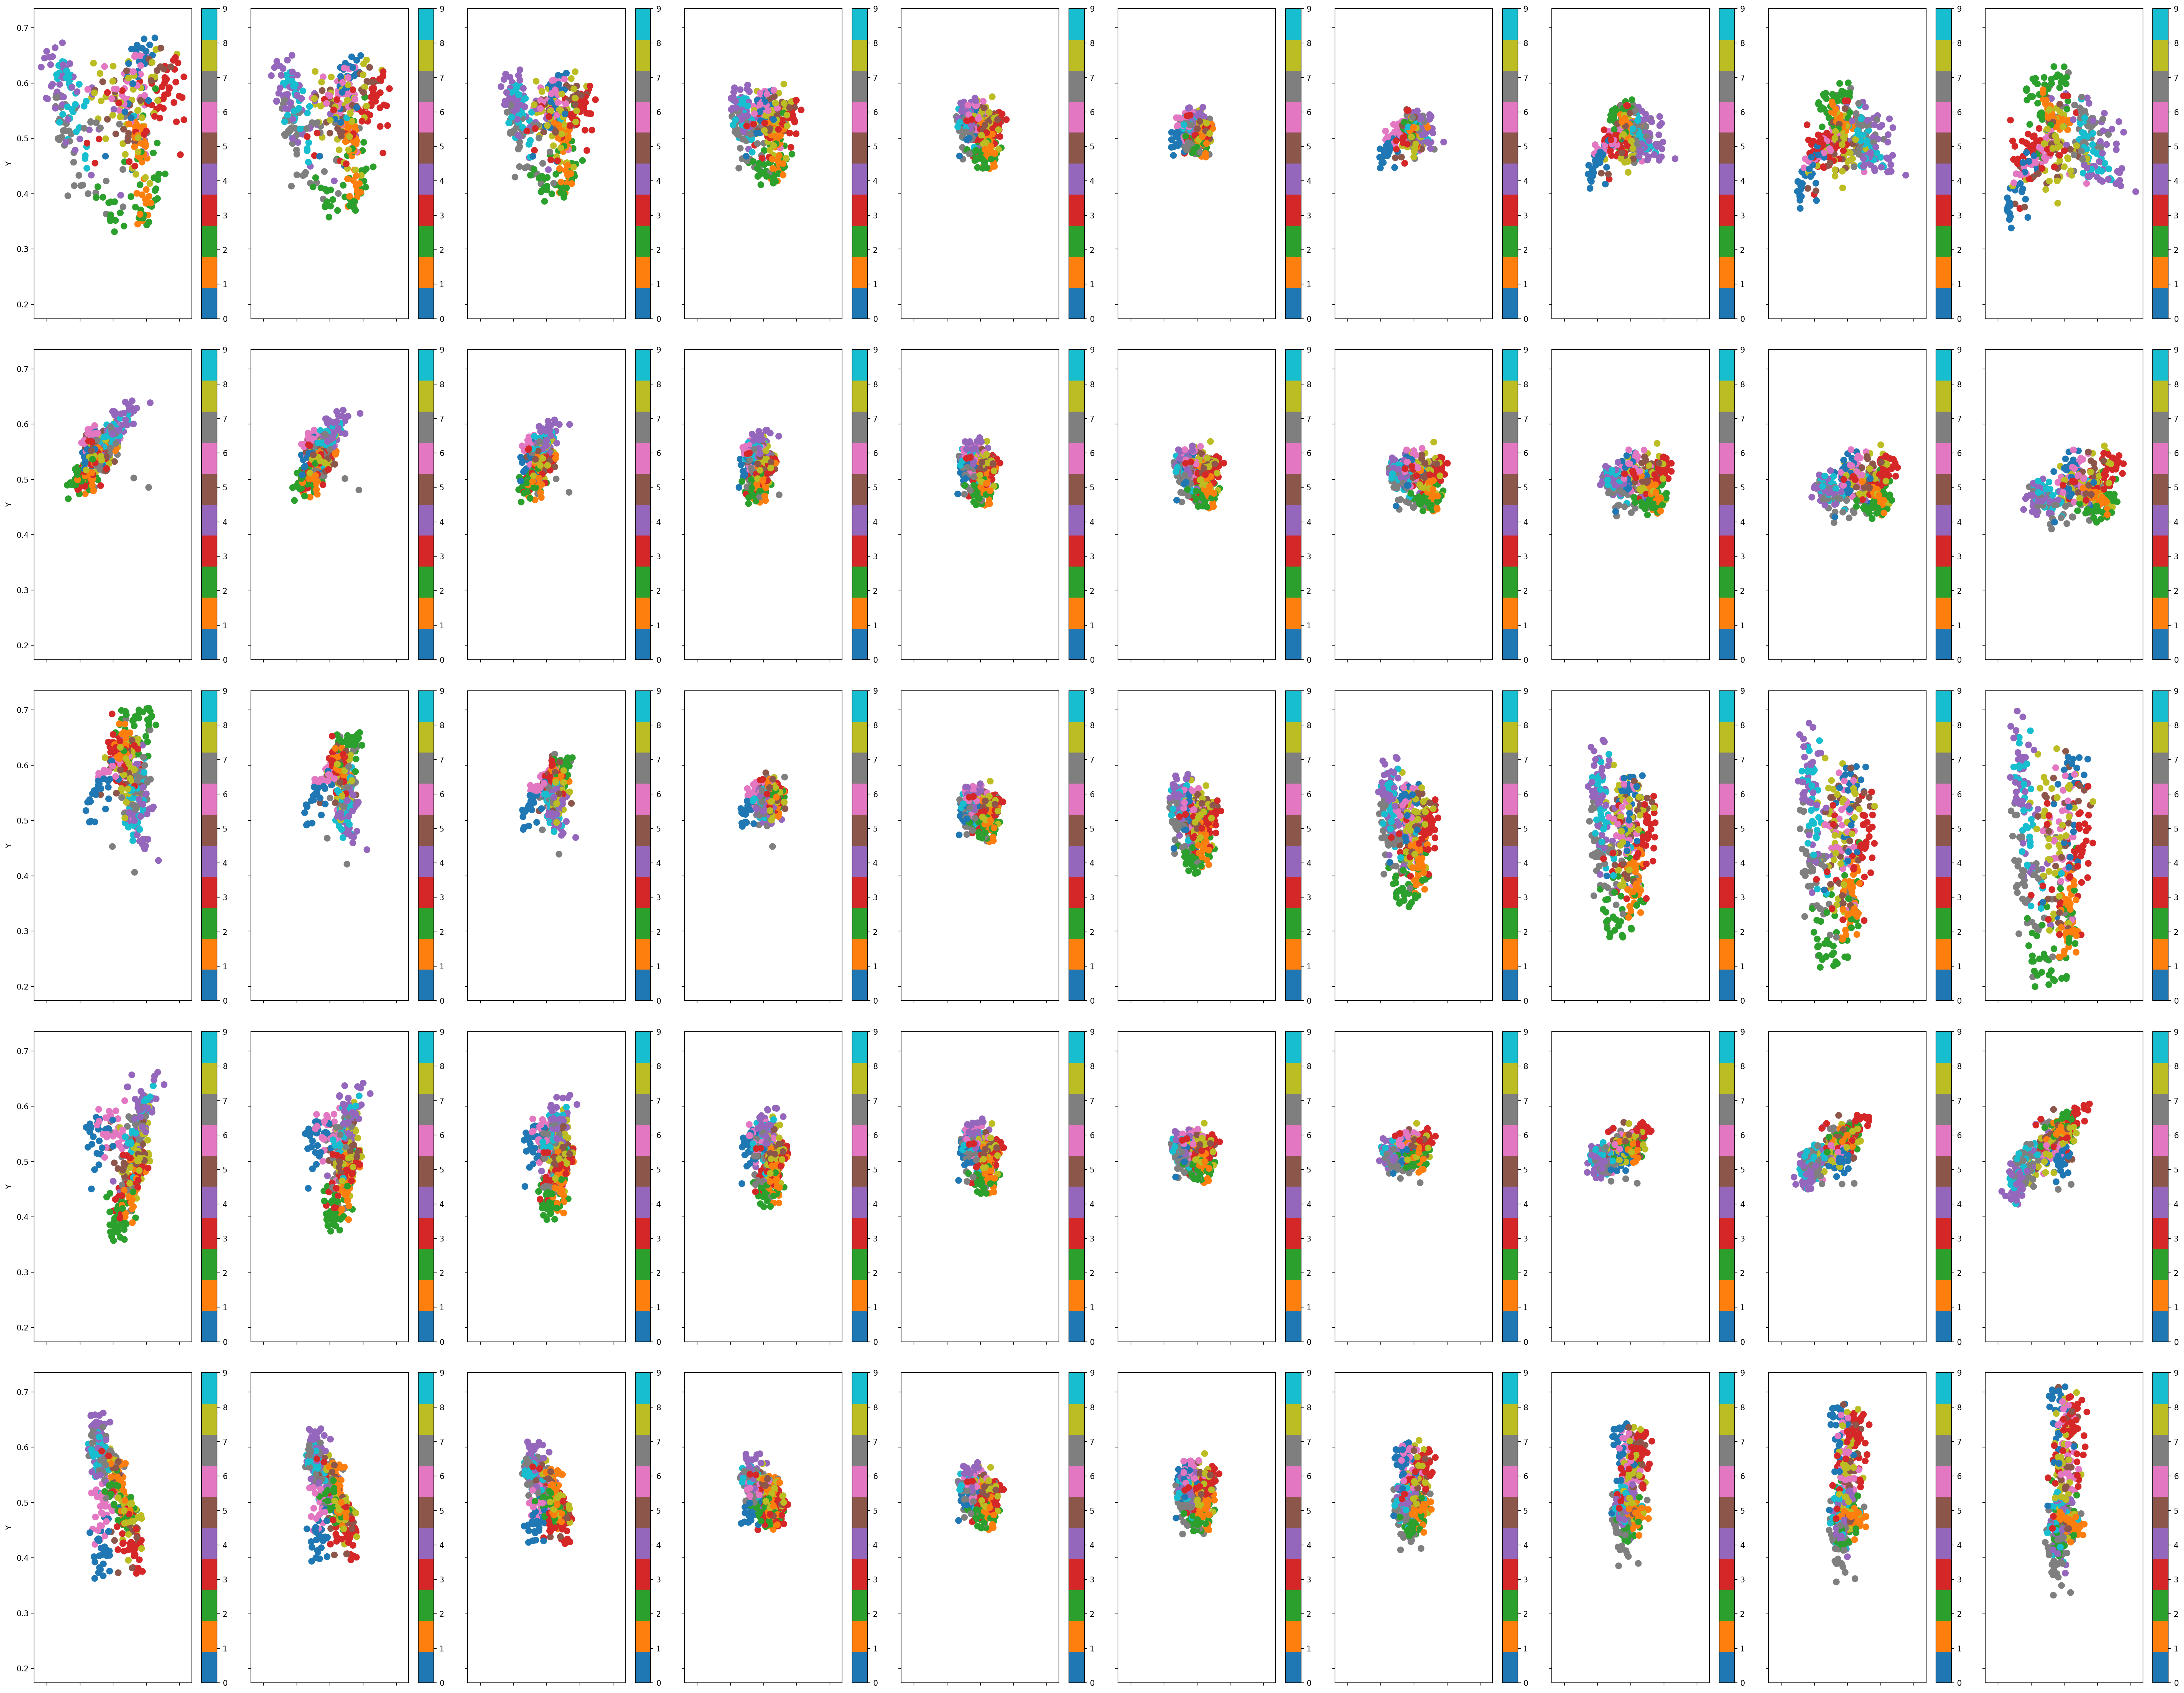

In [65]:
plot_reconstructed(vae,latent_dims, "vae", n=10, h=40, w=50, size=60)

## model export

In [76]:
model_path = './model/'
torch.save(vae.state_dict(), model_path + 'model.pt')

In [95]:
for key, value in vae.state_dict().items():
    print(key,"     : ", value.shape[0])

encoder.fc1.weight      :  512
encoder.fc1.bias      :  512
encoder.fc2.weight      :  5
encoder.fc2.bias      :  5
encoder.fc3.weight      :  5
encoder.fc3.bias      :  5
decoder.fc1.weight      :  512
decoder.fc1.bias      :  512
decoder.fc2.weight      :  800
decoder.fc2.bias      :  800


In [97]:
x = vae.state_dict()['encoder.fc3.bias'].shape

In [103]:
for key, value in vae.state_dict().items():
    print(value.shape)

torch.Size([512, 800])
torch.Size([512])
torch.Size([5, 512])
torch.Size([5])
torch.Size([5, 512])
torch.Size([5])
torch.Size([512, 5])
torch.Size([512])
torch.Size([800, 512])
torch.Size([800])
